Caricate righe totali: 54596  |  Shard mancanti: 0
Finesre uniche: 54568  |  Kept (post-cap): 54568  |  Drops: no_key=0, trimmed=28
=== MERGE COMPLETATO (dedup finestra globale) ===
Merged file: shards_flat/annotations/gen_out/filtered_queries_merged_0000_0009.json

Counts per bucket (train vs merged):
bucket
(0.0, 2.0)      2805
(2.0, 4.0)      2368
(4.0, 8.0)      2150
(8.0, 16.0)     1448
(16.0, 32.0)     865
(32.0, 60.0)     694
dtype: int64

bucket
(0.0, 2.0)      14949
(2.0, 4.0)      12688
(4.0, 8.0)      11406
(8.0, 16.0)      7687
(16.0, 32.0)     4491
(32.0, 60.0)     3347
dtype: int64

KS globali (dovrebbero scendere dopo dedup per finestra):
  KS(qs_rel): 0.0601
  KS(qe_rel): 0.0556
  KS(d_rel): 0.0355


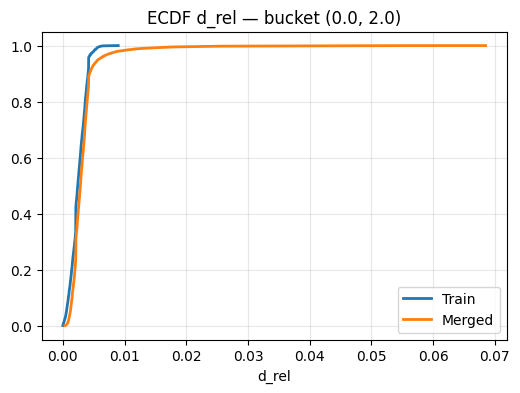

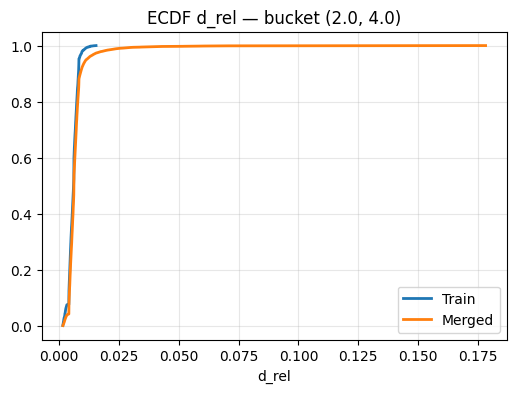

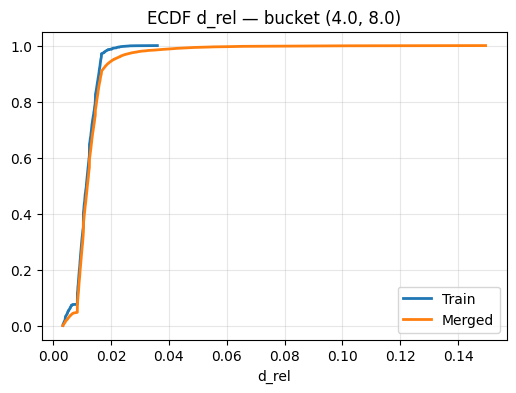

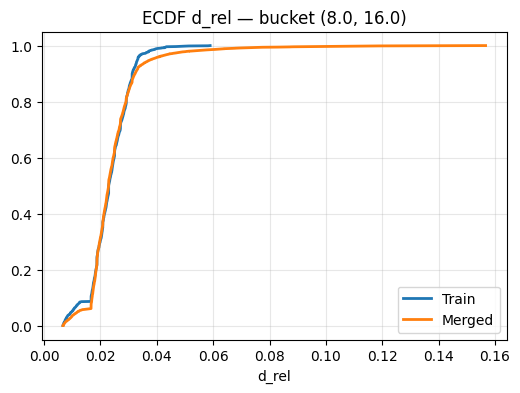

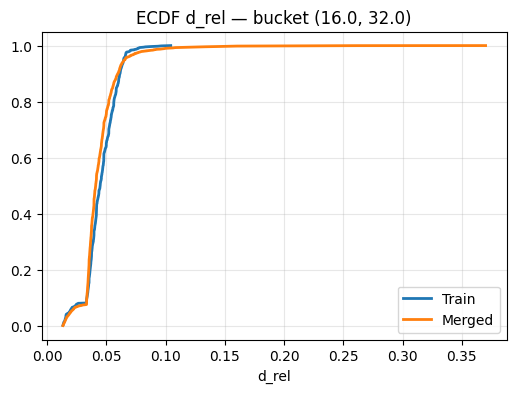

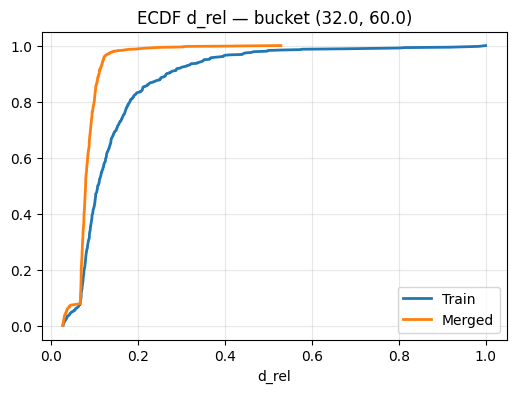

In [2]:
# === MERGE (dedup per finestra) + DIAGNOSTICA ECDF/KS ===
import os, json, csv, random
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ---------------- CONFIG ----------------
SHARDS_DIR      = "shards_flat/annotations/gen_out"             # dir contenente queries_shard_*.jsonl
OUT_MERGED      = os.path.join(SHARDS_DIR, "filtered_queries_merged_0000_0009.json")
OUT_COUNTS      = os.path.join(SHARDS_DIR, "filtered_queries_counts_0000_0009.csv")
FNAME_TPL       = "queries_shard_{:04d}.jsonl"
SHARD_MIN, SHARD_MAX = 0, 5

ROUND_S         = 3      # arrotondamento (s) per la chiave finestra: millisecondi
MAX_PER_SHARD   = None   # opzionale: cap per shard (None = disattivo), es. 6000
MAX_Q_PER_WINDOW = 1     # cap di domande per FINESTRA (1 consigliato per neutralità)
SEED            = 42     # riproducibilità in tie-break
random.seed(SEED)

# diagnostica vs train
TRAIN_JSON_PATH = "nlq_train.json"
DURATION_BUCKETS = [0,2,4,8,16,32,60]

# --------------- HELPERS ----------------
def load_any_json_or_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        data = f.read().strip()
    # prova JSON (array o oggetto)
    try:
        obj = json.loads(data)
        return obj if isinstance(obj, list) else [obj]
    except json.JSONDecodeError:
        pass
    # fallback: JSONL
    rows = []
    for line in data.splitlines():
        line = line.strip()
        if not line:
            continue
        try:
            rows.append(json.loads(line))
        except json.JSONDecodeError:
            continue
    return rows

def f2(x):
    try: return float(x)
    except: return None

def window_key(r, rnd=ROUND_S):
    vid = r.get("video_uid")
    cs, ce = f2(r.get("clip_start_sec")), f2(r.get("clip_end_sec"))
    qs, qe = f2(r.get("query_start_sec")), f2(r.get("query_end_sec"))
    if not vid or None in (cs,ce,qs,qe):
        return None
    return (vid, round(cs, rnd), round(ce, rnd), round(qs, rnd), round(qe, rnd))

def norm_query_text(r):
    return (r.get("template") or "", (r.get("query") or "").strip())

def pick_better(a, b):
    # Tie-break per MAX_Q_PER_WINDOW==1: preferisci score più alto se presente, altrimenti testo più lungo.
    sa = a.get("score"); sb = b.get("score")
    if isinstance(sa, (int,float)) and isinstance(sb, (int,float)):
        return a if sa >= sb else b
    return a if len((a.get("query") or "")) >= len((b.get("query") or "")) else b

def bucket_of(d, edges=DURATION_BUCKETS):
    for i in range(len(edges)-1):
        if edges[i] <= d < edges[i+1]:
            return (float(edges[i]), float(edges[i+1]))
    return (float(edges[-2]), float(edges[-1]))

def ecdf_vals(x):
    x = np.sort(np.asarray(x, float))
    y = np.arange(1, len(x)+1) / max(1, len(x))
    return x, y

# --------------- LOAD SHARDS -------------
all_rows = []
per_shard_counts = []
missing = []

for i in range(SHARD_MIN, SHARD_MAX+1):
    p = os.path.join(SHARDS_DIR, FNAME_TPL.format(i))
    if not os.path.exists(p):
        missing.append(p)
        continue
    rows = load_any_json_or_jsonl(p)
    if MAX_PER_SHARD is not None and len(rows) > MAX_PER_SHARD:
        # bilanciamento semplice (random subsample)
        rows = random.sample(rows, MAX_PER_SHARD)
    per_shard_counts.append({"shard": f"{i:04d}", "file": Path(p).name, "queries": len(rows)})
    all_rows.extend(rows)

print(f"Caricate righe totali: {len(all_rows)}  |  Shard mancanti: {len(missing)}")

# --------------- DEDUP PER FINESTRA --------------
# Collassa globalmente per finestra (video, cs, ce, qs, qe) con cap MAX_Q_PER_WINDOW
win_to_rows = defaultdict(list)
drops_no_key = 0

for r in all_rows:
    k = window_key(r)
    if k is None:
        drops_no_key += 1
        continue
    win_to_rows[k].append(r)

collapsed = []
dup_trimmed = 0

for k, lst in win_to_rows.items():
    if MAX_Q_PER_WINDOW <= 1:
        # tieni 1 sola riga per finestra (migliore tra i duplicati)
        best = lst[0]
        for cand in lst[1:]:
            best = pick_better(best, cand)
        collapsed.append(best)
        dup_trimmed += (len(lst) - 1)
    else:
        # tieni fino a MAX_Q_PER_WINDOW testi unici per finestra
        uniq = {}
        for r in lst:
            t = norm_query_text(r)
            if t not in uniq:
                uniq[t] = r
        chosen = list(uniq.values())
        if len(chosen) > MAX_Q_PER_WINDOW:
            # criteri: ordina per score decrescente se presente, poi lunghezza testo
            def ranker(x):
                sc = x.get("score")
                sc = sc if isinstance(sc, (int,float)) else 0.0
                return (-sc, -len((x.get("query") or "")))
            chosen = sorted(chosen, key=ranker)[:MAX_Q_PER_WINDOW]
        collapsed.extend(chosen)
        dup_trimmed += (len(lst) - len(chosen))

print(f"Finesre uniche: {len(win_to_rows)}  |  Kept (post-cap): {len(collapsed)}  |  Drops: no_key={drops_no_key}, trimmed={dup_trimmed}")

# --------------- SAVE MERGED ----------------------
with open(OUT_MERGED, "w", encoding="utf-8") as f:
    json.dump(collapsed, f, ensure_ascii=False, indent=2)

with open(OUT_COUNTS, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["shard","file","queries"])
    w.writeheader(); w.writerows(per_shard_counts)

print("=== MERGE COMPLETATO (dedup finestra globale) ===")
print(f"Merged file: {OUT_MERGED}")

if missing:
    print("[ATTENZIONE] Mancanti:")
    for p in missing: print(" -", p)

# --------------- DIAGNOSTICA vs TRAIN -------------
# Load Train
with open(TRAIN_JSON_PATH, "r") as f:
    train = json.load(f)

train_rows = []
for v in train["videos"]:
    for c in v.get("clips", []):
        cs, ce = float(c["clip_start_sec"]), float(c["clip_end_sec"])
        L = ce - cs
        if L <= 0: continue
        for a in c.get("annotations", []):
            for q in a.get("language_queries", []):
                s = q.get("clip_start_sec"); e = q.get("clip_end_sec")
                if s is None or e is None:
                    sv = q.get("video_start_sec"); ev = q.get("video_end_sec"); cvs = c.get("video_start_sec")
                    if sv is None or ev is None or cvs is None: continue
                    s = (float(sv) - float(cvs)) + cs; e = (float(ev) - float(cvs)) + cs
                s, e = float(s), float(e)
                d = e - s
                if d <= 0: continue
                train_rows.append({
                    "bucket": bucket_of(d),
                    "qs_rel": (s - cs)/L,
                    "qe_rel": (e - cs)/L,
                    "d_rel": d/L
                })

df_train = pd.DataFrame(train_rows)

# Build df_post da 'collapsed'
post_rows = []
for r in collapsed:
    cs, ce = f2(r.get("clip_start_sec")), f2(r.get("clip_end_sec"))
    qs, qe = f2(r.get("query_start_sec")), f2(r.get("query_end_sec"))
    if None in (cs,ce,qs,qe): continue
    L = ce - cs; d = qe - qs
    if d <= 0 or L <= 0: continue
    post_rows.append({
        "bucket": bucket_of(d),
        "qs_rel": (qs - cs)/L,
        "qe_rel": (qe - cs)/L,
        "d_rel": d/L,
        "template": r.get("template","")
    })
df_post = pd.DataFrame(post_rows)

print("\nCounts per bucket (train vs merged):")
print(df_train.groupby("bucket").size())
print()
print(df_post.groupby("bucket").size())

# KS globali
print("\nKS globali (dovrebbero scendere dopo dedup per finestra):")
for field in ["qs_rel","qe_rel","d_rel"]:
    ks = ks_2samp(df_train[field], df_post[field]).statistic
    print(f"  KS({field}): {ks:.4f}")

# ECDF per bucket su d_rel
buckets = sorted(df_train["bucket"].unique())
for b in buckets:
    t = df_train[df_train["bucket"]==b]["d_rel"].values
    p = df_post[df_post["bucket"]==b]["d_rel"].values
    if len(t)<10 or len(p)<10: continue
    x_t, y_t = ecdf_vals(t); x_p, y_p = ecdf_vals(p)
    plt.figure(figsize=(6,4))
    plt.plot(x_t, y_t, label="Train", lw=2)
    plt.plot(x_p, y_p, label="Merged", lw=2)
    plt.title(f"ECDF d_rel — bucket {b}")
    plt.xlabel("d_rel"); plt.grid(True, alpha=0.3); plt.legend()
    plt.show()



[TEMPLATE] top 20 per frequenza (train vs merged):
 - Objects: Where is object X before / after event Y?: train=0.161, merged=0.168
 - Place: Where did I put X?: train=0.142, merged=0.141
 - Objects: Where is object X?: train=0.129, merged=0.133
 - Objects: What did I put in X?: train=0.112, merged=0.097
 - Objects: How many X’s? (quantity question): train=0.090, merged=0.088
 - Objects: In what location did I see object X ?: train=0.083, merged=0.086
 - Objects: What X did I Y?: train=0.081, merged=0.081
 - Objects: What X is Y?: train=0.074, merged=0.077
 - Objects: State of an object: train=0.053, merged=0.052
 - People: Who did I interact with when I did activity X?: train=0.026, merged=0.025
 - Objects: Where is my object X?: train=0.021, merged=0.022
 - People: Who did I talk to in location X?: train=0.019, merged=0.019
 - People: When did I talk to or interact with person with role X?: train=0.009, merged=0.009

[TEMPLATE] Chi2(stat)=161.00  KL(P||Q)=0.002


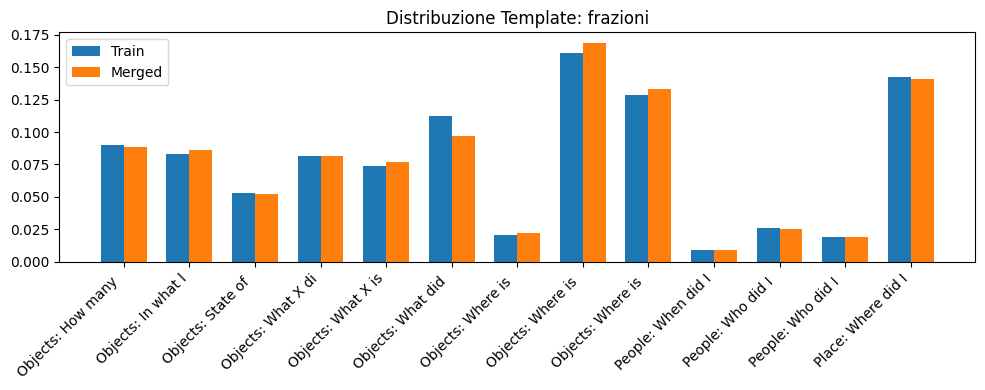


[BUCKET] frazioni (train vs merged):
 - (0.0, 2.0): train=0.272, merged=0.274
 - (2.0, 4.0): train=0.229, merged=0.233
 - (4.0, 8.0): train=0.208, merged=0.209
 - (8.0, 16.0): train=0.140, merged=0.141
 - (16.0, 32.0): train=0.084, merged=0.082
 - (32.0, 60.0): train=0.067, merged=0.061

[BUCKET] Chi2(stat)=33.24  KL(P||Q)=0.000


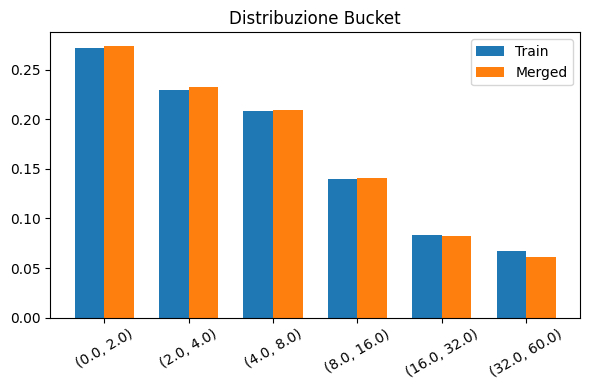


[TEMPLATE×BUCKET] Chi2(stat)=220.22


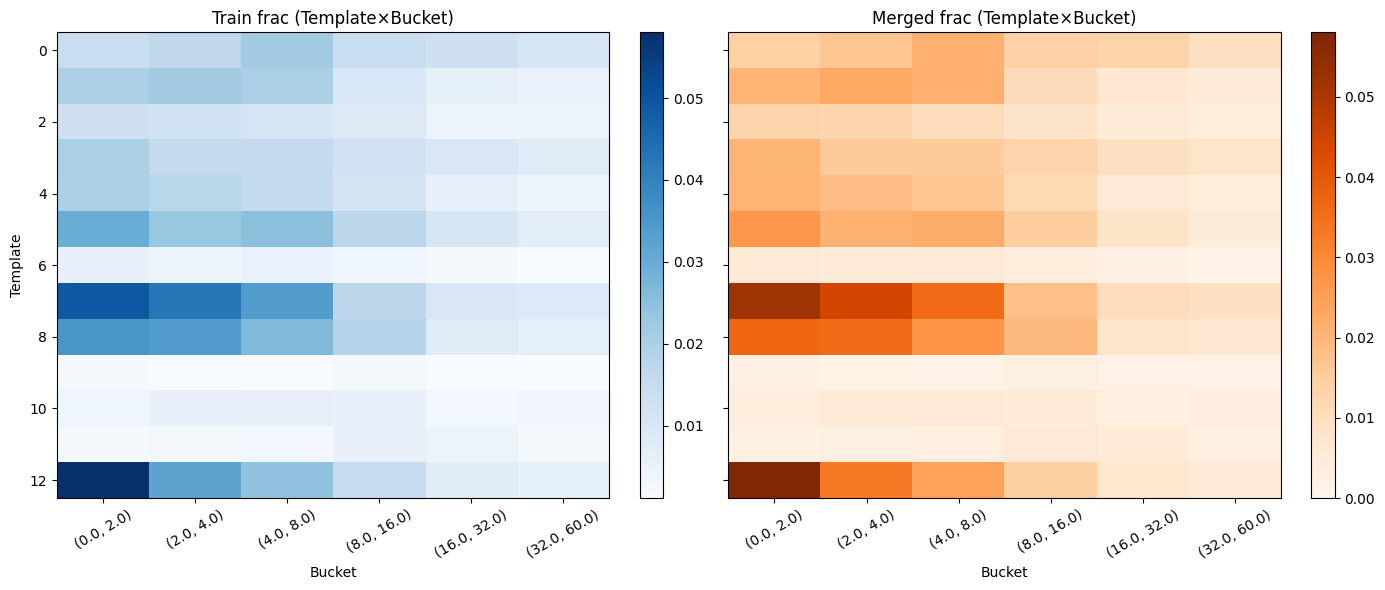

In [3]:
# === DIAGNOSTICA ESTESA: Template, Bucket, Template×Bucket ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict, Counter
from scipy.stats import chisquare
from math import log

# Assumiamo di avere df_train (con colonne: bucket, qs_rel, qe_rel, d_rel, template)
# e df_post (idem) già costruiti nella cella subito sopra.
# Se df_train non ha 'template', ricostruiscilo velocemente:
if "template" not in df_train.columns:
    train_tpl_rows = []
    with open(TRAIN_JSON_PATH,"r") as f:
        T = json.load(f)
    for v in T["videos"]:
        for c in v.get("clips",[]):
            cs, ce = float(c["clip_start_sec"]), float(c["clip_end_sec"])
            L = ce - cs
            if L <= 0: continue
            for a in c.get("annotations",[]):
                for q in a.get("language_queries",[]):
                    t = q.get("template")
                    s = q.get("clip_start_sec"); e = q.get("clip_end_sec")
                    if s is None or e is None:
                        sv = q.get("video_start_sec"); ev = q.get("video_end_sec"); cvs = c.get("video_start_sec")
                        if sv is None or ev is None or cvs is None: continue
                        s = (float(sv) - float(cvs)) + cs; e = (float(ev) - float(cvs)) + cs
                    d = float(e) - float(s)
                    if d <= 0: continue
                    train_tpl_rows.append({
                        "template": t,
                        "bucket": bucket_of(d),
                        "qs_rel": (float(s)-cs)/L,
                        "qe_rel": (float(e)-cs)/L,
                        "d_rel": d/L
                    })
    df_train = pd.DataFrame(train_tpl_rows)

def frac(series):
    c = series.value_counts().sort_index()
    f = c / max(1, c.sum())
    return c, f

def kl_div(p, q, eps=1e-12):
    # KL(P||Q) su supporto comune
    idx = sorted(set(p.index) | set(q.index))
    P = np.array([p.get(i,0.0) for i in idx], float) + eps
    Q = np.array([q.get(i,0.0) for i in idx], float) + eps
    P /= P.sum(); Q /= Q.sum()
    return float(np.sum(P * np.log(P / Q)))

def chisq_counts(c_train, c_post):
    # armonizza supporto
    idx = sorted(set(c_train.index) | set(c_post.index))
    o = np.array([c_post.get(i,0) for i in idx], float)
    e = np.array([c_train.get(i,0) for i in idx], float)
    if e.sum() == 0 or o.sum() == 0:
        return np.nan
    # scala le attese alla stessa massa di o
    e = e * (o.sum() / max(1.0, e.sum()))
    try:
        return float(chisquare(o, e)[0])
    except Exception:
        return np.nan

# 1) Distribuzione per TEMPLATE
ct, ft = frac(df_train["template"])
cp, fp = frac(df_post["template"])
print("\n[TEMPLATE] top 20 per frequenza (train vs merged):")
top = (ft.sort_values(ascending=False).index.tolist())[:20]
for t in top:
    print(f" - {t}: train={ft.get(t,0):.3f}, merged={fp.get(t,0):.3f}")

chi_t = chisq_counts(ct, cp)
kl_t  = kl_div(ft, fp)
print(f"\n[TEMPLATE] Chi2(stat)={chi_t:.2f}  KL(P||Q)={kl_t:.3f}")

plt.figure(figsize=(10,4))
idx = sorted(set(ft.index)|set(fp.index))
x = np.arange(len(idx))
plt.bar(x-0.35/2, [ft.get(i,0) for i in idx], width=0.35, label="Train")
plt.bar(x+0.35/2, [fp.get(i,0) for i in idx], width=0.35, label="Merged")
plt.xticks(x, [str(i)[:18] for i in idx], rotation=45, ha="right")
plt.title("Distribuzione Template: frazioni")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Distribuzione per BUCKET
ctb, ftb = frac(df_train["bucket"])
cpb, fpb = frac(df_post["bucket"])
print("\n[BUCKET] frazioni (train vs merged):")
for b in sorted(set(ftb.index)|set(fpb.index)):
    print(f" - {b}: train={ftb.get(b,0):.3f}, merged={fpb.get(b,0):.3f}")

chi_b = chisq_counts(ctb, cpb)
kl_b  = kl_div(ftb, fpb)
print(f"\n[BUCKET] Chi2(stat)={chi_b:.2f}  KL(P||Q)={kl_b:.3f}")

plt.figure(figsize=(6,4))
idx = sorted(set(ftb.index)|set(fpb.index))
x = np.arange(len(idx))
plt.bar(x-0.35/2, [ftb.get(i,0) for i in idx], width=0.35, label="Train")
plt.bar(x+0.35/2, [fpb.get(i,0) for i in idx], width=0.35, label="Merged")
plt.xticks(x, [str(i) for i in idx], rotation=30); plt.title("Distribuzione Bucket")
plt.legend(); plt.tight_layout(); plt.show()

# 3) Congiunta TEMPLATE×BUCKET (heatmap frazioni)
def joint_frac(df):
    tab = df.pivot_table(index="template", columns="bucket", values="d_rel", aggfunc="count").fillna(0)
    tab = tab / max(1, tab.to_numpy().sum())
    return tab

Jt = joint_frac(df_train)
Jp = joint_frac(df_post)

# allinea indici/colonne
idx_all = sorted(set(Jt.index)|set(Jp.index))
col_all = sorted(set(Jt.columns)|set(Jp.columns))
Jt = Jt.reindex(index=idx_all, columns=col_all, fill_value=0)
Jp = Jp.reindex(index=idx_all, columns=col_all, fill_value=0)

# Chi2 su counts per cella (scala attese)
Ct = (Jt * max(1, len(df_train))).round().astype(int)
Cp = (Jp * max(1, len(df_post))).round().astype(int)
chi_tb = chisq_counts(Ct.stack(), Cp.stack())
print(f"\n[TEMPLATE×BUCKET] Chi2(stat)={chi_tb:.2f}")

fig, ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
im0 = ax[0].imshow(Jt.to_numpy(), aspect="auto", cmap="Blues")
ax[0].set_title("Train frac (Template×Bucket)")
ax[0].set_xlabel("Bucket"); ax[0].set_ylabel("Template")
ax[0].set_xticks(range(len(col_all))); ax[0].set_xticklabels([str(c) for c in col_all], rotation=30)
fig.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(Jp.to_numpy(), aspect="auto", cmap="Oranges", vmin=0, vmax=np.max(Jt.to_numpy()))
ax[1].set_title("Merged frac (Template×Bucket)")
ax[1].set_xlabel("Bucket")
ax[1].set_xticks(range(len(col_all))); ax[1].set_xticklabels([str(c) for c in col_all], rotation=30)
fig.colorbar(im1, ax=ax[1], fraction=0.046)
plt.tight_layout(); plt.show()


In [4]:
# === Distribution Matching SEMPLICE 2D (Template x Durata) - NO DEDUP ===
import json, os, random
from collections import defaultdict
import numpy as np
from tqdm.auto import tqdm

# ---------------- CONFIG ----------------
FILTERED_QUERIES_PATH = "shards_flat/annotations/gen_out/filtered_queries_merged_0000_0009.json"
TRAIN_JSON_PATH       = "nlq_train.json"
OUTPUT_MATCHED_PATH   = "nlq_pretrain.json"

DURATION_BUCKETS = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0, 60.0]
FINAL_TARGET     = 50000
SEED             = 42

random.seed(SEED)
rng = np.random.default_rng(seed=SEED)

# ---------------- HELPERS ----------------
def bucket_of(d):
    for i in range(len(DURATION_BUCKETS) - 1):
        if DURATION_BUCKETS[i] <= d < DURATION_BUCKETS[i + 1]:
            return (float(DURATION_BUCKETS[i]), float(DURATION_BUCKETS[i + 1]))
    return (float(DURATION_BUCKETS[-2]), float(DURATION_BUCKETS[-1]))

def build_joint_budget_2d(trainobj, totalqueries):
    counts = defaultdict(int)
    for v in trainobj['videos']:
        for c in v.get('clips', []):
            cs, ce = float(c["clip_start_sec"]), float(c["clip_end_sec"])
            for a in c.get("annotations", []):
                for q in a.get("language_queries", []):
                    t = q.get('template')
                    s = q.get("clip_start_sec"); e = q.get("clip_end_sec")
                    # Fallback se mancano i tempi relativi alla clip
                    if s is None or e is None:
                         sv = q.get("video_start_sec"); ev = q.get("video_end_sec"); cvs = c.get("video_start_sec")
                         if None in (sv, ev, cvs): continue
                         s, e = (float(sv) - float(cvs)) + cs, (float(ev) - float(cvs)) + cs
                    
                    d = float(e) - float(s)
                    if d <= 1e-9: continue
                    b = bucket_of(d)
                    counts[(t, b)] += 1

    # Normalizzazione al target
    keys = list(counts.keys())
    vals = np.array([counts[k] for k in keys], dtype=float)
    probs = vals / max(1, vals.sum())
    scaled = probs * totalqueries
    floors = np.floor(scaled).astype(int)
    # Distribuzione resto
    rest = totalqueries - floors.sum()
    for i in np.argsort(-(scaled - floors))[:rest]:
        floors[i] += 1
    return {keys[i]: int(floors[i]) for i in range(len(keys))}

# ---------------- 1. CALCOLO TARGET 2D ----------------
print(">>> [1/4] Carico Train e calcolo target 2D...")
with open(TRAIN_JSON_PATH, 'r') as f:
    train_json = json.load(f)
T_target = build_joint_budget_2d(train_json, FINAL_TARGET)
print(f"   Target totale: {sum(T_target.values())} query in {len(T_target)} celle (Template x Bucket)")

# ---------------- 2. CARICAMENTO E INDICIZZAZIONE ----------------
print(f">>> [2/4] Carico candidati da {FILTERED_QUERIES_PATH}...")
with open(FILTERED_QUERIES_PATH, 'r') as f:
    merged = json.load(f)

catalog = defaultdict(list)
for q in merged:
    # Usa 'safe_float' inline per robustezza
    try:
        qs, qe = float(q["query_start_sec"]), float(q["query_end_sec"])
        tpl = q.get("template")
    except (ValueError, TypeError, KeyError):
        continue # Salta righe malformate

    d = qe - qs
    if d <= 1e-9 or not tpl: continue
    
    b = bucket_of(d)
    catalog[(tpl, b)].append(q)

print(f"   Candidati validi indicizzati: {sum(len(v) for v in catalog.values())}")

# ---------------- 3. CAMPIONAMENTO (SEMPLICE) ----------------
print(">>> [3/4] Esecuzione campionamento 2D...")
selected = []
deficits = 0

for cell, target in tqdm(T_target.items(), desc="Sampling celle"):
    pool = catalog.get(cell, [])
    n_avail = len(pool)
    
    if n_avail == 0:
        deficits += target
        continue
        
    if n_avail >= target:
        # Abbiamo abbastanza candidati: prendine 'target' senza rimpiazzo
        # Usiamo rng.choice sugli indici per velocità
        indices = rng.choice(n_avail, size=target, replace=False)
        for i in indices:
            selected.append(pool[i])
    else:
        # Non abbastanza: prendili tutti + duplicati (replace=True) per arrivare al target
        selected.extend(pool) # Prendi tutti gli unici
        needed = target - n_avail
        # Campiona il resto con rimpiazzo
        indices = rng.choice(n_avail, size=needed, replace=True)
        for i in indices:
            selected.append(pool[i])

print(f">>> SELEZIONATI: {len(selected)} (Target: {FINAL_TARGET})")
if deficits > 0:
    print(f"   [WARN] Impossibile soddisfare {deficits} richieste (celle vuote nel catalogo).")

# ---------------- 4. SALVATAGGIO ----------------
with open(OUTPUT_MATCHED_PATH, 'w') as f:
    json.dump(selected, f, indent=2)
print(f">>> Salvato: {OUTPUT_MATCHED_PATH}")

/home/nicolo/ingegneriaMatematica/machineLearning/venv-ia/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>>> [1/4] Carico Train e calcolo target 2D...
   Target totale: 50000 query in 84 celle (Template x Bucket)
>>> [2/4] Carico candidati da shards_flat/annotations/gen_out/filtered_queries_merged_0000_0009.json...
   Candidati validi indicizzati: 54568
>>> [3/4] Esecuzione campionamento 2D...


Sampling celle: 100%|██████████| 84/84 [00:00<00:00, 8384.81it/s]

>>> SELEZIONATI: 49714 (Target: 50000)
   [WARN] Impossibile soddisfare 286 richieste (celle vuote nel catalogo).


>>> Salvato: nlq_pretrain.json


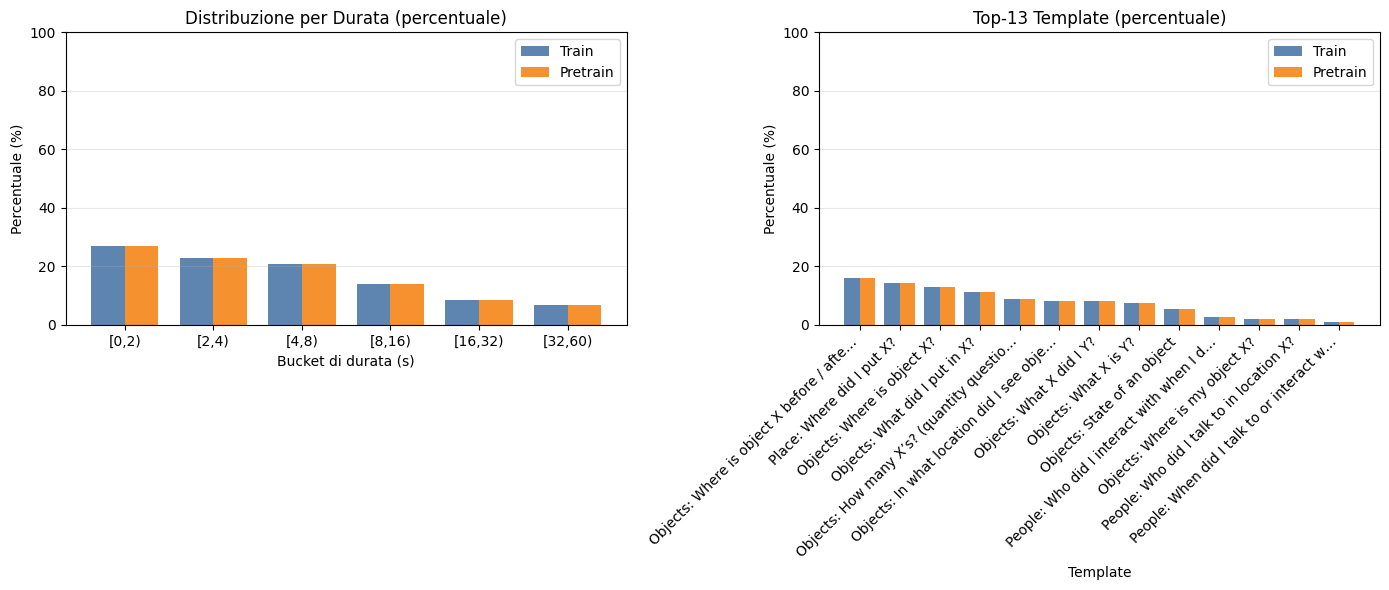

In [5]:
# ==== Grafici normalizzati (Train vs Pretrain) ====
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# Usa gli stessi path che hai già impostato
TRAIN_JSON_PATH = "nlq_train.json"
PRETRAIN_JSON_PATH = "nlq_pretrain.json"  # o il tuo OUTPUT_MATCHED_PATH
DURATION_BUCKETS = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0, 60.0]
TOPN_TEMPLATES = 13  # cambia a piacere

def canonical_bucket(b):
    if isinstance(b, (tuple, list, np.ndarray)):
        return (float(b[0]), float(b[1]))
    return b

def bucket_of(d, edges=DURATION_BUCKETS):
    for i in range(len(edges)-1):
        if edges[i] <= d < edges[i+1]:
            return canonical_bucket((edges[i], edges[i+1]))
    return canonical_bucket((edges[-2], edges[-1]))

# ---------- Load ----------
with open(TRAIN_JSON_PATH, "r") as f:
    train_json = json.load(f)
with open(PRETRAIN_JSON_PATH, "r") as f:
    pre_json = json.load(f)

# ---------- Extract durations and templates ----------
train_durs, train_tpls = [], []
for v in train_json["videos"]:
    for c in v["clips"]:
        for a in c["annotations"]:
            for q in a.get("language_queries", []):
                t = q.get("template")
                s = q.get("video_start_sec", q.get("clip_start_sec"))
                e = q.get("video_end_sec", q.get("clip_end_sec"))
                if t is None or s is None or e is None:
                    continue
                d = float(e) - float(s)
                if d > 0:
                    train_durs.append(d)
                    train_tpls.append(t)

pre_durs, pre_tpls = [], []
for q in pre_json:
    t = q.get("template")
    s = q.get("query_start_sec")
    e = q.get("query_end_sec")
    if t is None or s is None or e is None:
        continue
    d = float(e) - float(s)
    if d > 0:
        pre_durs.append(d)
        pre_tpls.append(t)

# ---------- Duration buckets (counts -> %) ----------
def bucket_counts(durations, edges):
    counts = defaultdict(int)
    for d in durations:
        counts[bucket_of(d, edges)] += 1
    ordered = [(canonical_bucket((edges[i], edges[i+1])), counts[canonical_bucket((edges[i], edges[i+1]))])
               for i in range(len(edges)-1)]
    return ordered

train_bucket_counts = bucket_counts(train_durs, DURATION_BUCKETS)
pre_bucket_counts   = bucket_counts(pre_durs,  DURATION_BUCKETS)

bucket_labels = [f"[{lo:.0f},{hi:.0f})" for (lo, hi), _ in train_bucket_counts]
train_vals = np.array([c for _, c in train_bucket_counts], dtype=float)
pre_vals   = np.array([c for _, c in pre_bucket_counts],   dtype=float)

train_pct = 100 * train_vals / max(1, train_vals.sum())
pre_pct   = 100 * pre_vals   / max(1, pre_vals.sum())

# ---------- Template distrib (counts -> %) ----------
train_tpl_counter = Counter(train_tpls)
pre_tpl_counter   = Counter(pre_tpls)
top_tpls = [tpl for tpl, _ in train_tpl_counter.most_common(TOPN_TEMPLATES)]

train_total_tpl = max(1, sum(train_tpl_counter.values()))
pre_total_tpl   = max(1, sum(pre_tpl_counter.values()))

train_tpl_pct = [100 * train_tpl_counter.get(tpl, 0) / train_total_tpl for tpl in top_tpls]
pre_tpl_pct   = [100 * pre_tpl_counter.get(tpl, 0)   / pre_total_tpl   for tpl in top_tpls]

# ---------- Plot ----------
plt.figure(figsize=(14, 6))
w = 0.38

# Subplot 1: Durata normalizzata
ax1 = plt.subplot(1, 2, 1)
x = np.arange(len(bucket_labels))
ax1.bar(x - w/2, train_pct, width=w, label="Train", alpha=0.9, color="#4C78A8")
ax1.bar(x + w/2, pre_pct,   width=w, label="Pretrain", alpha=0.9, color="#F58518")
ax1.set_xticks(x)
ax1.set_xticklabels(bucket_labels, rotation=0)
ax1.set_title("Distribuzione per Durata (percentuale)")
ax1.set_xlabel("Bucket di durata (s)")
ax1.set_ylabel("Percentuale (%)")
ax1.set_ylim(0, 100)
ax1.grid(axis="y", alpha=0.3)
ax1.legend()

# Subplot 2: Template normalizzato
ax2 = plt.subplot(1, 2, 2)
x2 = np.arange(len(top_tpls))
ax2.bar(x2 - w/2, train_tpl_pct, width=w, label="Train", alpha=0.9, color="#4C78A8")
ax2.bar(x2 + w/2, pre_tpl_pct,   width=w, label="Pretrain", alpha=0.9, color="#F58518")
ax2.set_xticks(x2)
ax2.set_xticklabels([t[:40] + ("…" if len(t) > 40 else "") for t in top_tpls], rotation=45, ha="right")
ax2.set_title(f"Top-{TOPN_TEMPLATES} Template (percentuale)")
ax2.set_xlabel("Template")
ax2.set_ylabel("Percentuale (%)")
ax2.set_ylim(0, 100)
ax2.grid(axis="y", alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Opzionale: salva
# plt.savefig("dist_train_vs_pretrain_percent.png", dpi=200, bbox_inches="tight")


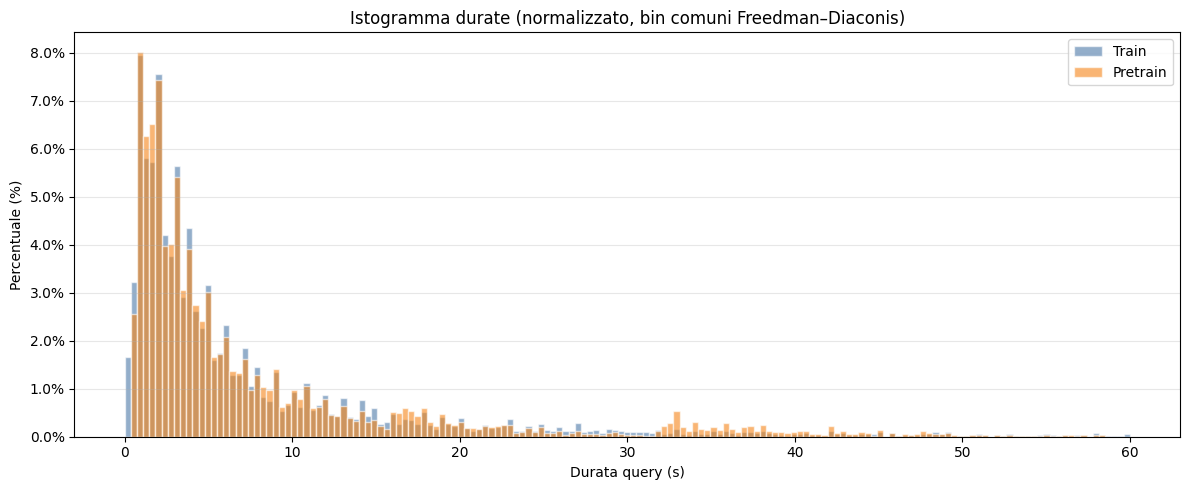

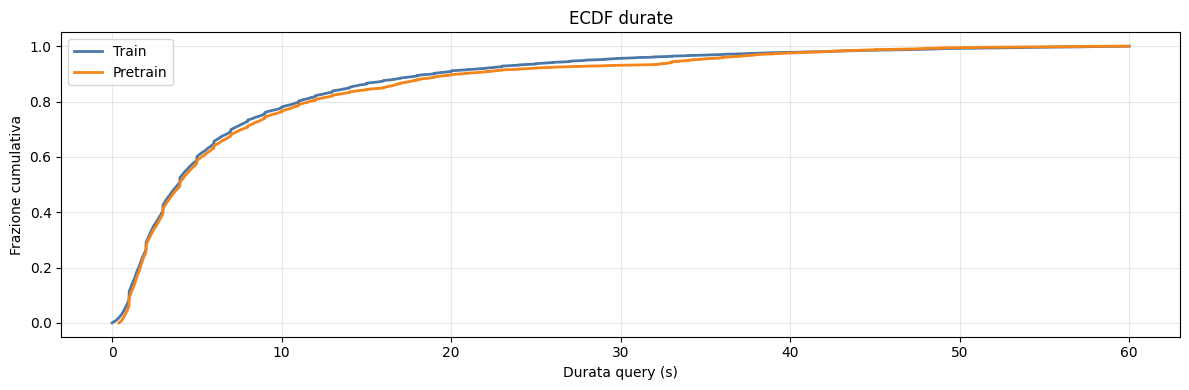

In [6]:
# ==== Istogramma durate normalizzato (percentuali) — FIX pesi ====
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

TRAIN_JSON_PATH = "nlq_train.json"
PRETRAIN_JSON_PATH = "nlq_pretrain.json"
RANGE_MAX = 60.0
RANGE_MIN = 0.0
EPS = 1e-9

def extract_train_durations(train_json):
    durs = []
    for v in train_json["videos"]:
        for c in v["clips"]:
            for a in c["annotations"]:
                for q in a.get("language_queries", []):
                    s = q.get("video_start_sec", q.get("clip_start_sec"))
                    e = q.get("video_end_sec",   q.get("clip_end_sec"))
                    if s is None or e is None:
                        continue
                    d = float(e) - float(s)
                    if d > 0:
                        durs.append(d)
    return np.asarray(durs, dtype=float)

def extract_pretrain_durations(pre_json):
    durs = []
    for q in pre_json:
        s = q.get("query_start_sec")
        e = q.get("query_end_sec")
        if s is None or e is None:
            continue
        d = float(e) - float(s)
        if d > 0:
            durs.append(d)
    return np.asarray(durs, dtype=float)

def clip_range(x, lo=RANGE_MIN, hi=RANGE_MAX):
    x = np.asarray(x, dtype=float)
    return x[(x >= lo) & (x <= hi)]

def freedman_diaconis_bins(x, lo=RANGE_MIN, hi=RANGE_MAX, fallback_bins=40):
    x = clip_range(x, lo, hi)
    n = len(x)
    if n < 2:
        return np.linspace(lo, hi, fallback_bins+1)
    q75, q25 = np.percentile(x, [75, 25])
    iqr = max(q75 - q25, EPS)
    bw = 2 * iqr / np.cbrt(n)
    if bw <= 0:
        return np.linspace(lo, hi, fallback_bins+1)
    nbins = int(np.ceil((hi - lo) / bw))
    nbins = min(max(nbins, 10), 200)
    return np.linspace(lo, hi, nbins+1)

# Load
with open(TRAIN_JSON_PATH, "r") as f:
    train_json = json.load(f)
with open(PRETRAIN_JSON_PATH, "r") as f:
    pre_json = json.load(f)

# Durations
train_durs = extract_train_durations(train_json)
pre_durs   = extract_pretrain_durations(pre_json)

# CLIP PRIMA, poi crea i pesi della stessa shape
train_clip = clip_range(train_durs)
pre_clip   = clip_range(pre_durs)

# Bins comuni su unione clippata
all_clip = np.concatenate([train_clip, pre_clip])
bin_edges = freedman_diaconis_bins(all_clip)

# Pesi normalizzati a percentuale (somma 100 per dataset)
w_train = np.full_like(train_clip, fill_value=(100.0 / max(1, len(train_clip))), dtype=float)
w_pre   = np.full_like(pre_clip,   fill_value=(100.0 / max(1, len(pre_clip))),   dtype=float)

# Plot
plt.figure(figsize=(12, 5))
plt.hist(train_clip, bins=bin_edges, weights=w_train,
         alpha=0.6, color="#4C78A8", edgecolor="white", label="Train")
plt.hist(pre_clip,   bins=bin_edges, weights=w_pre,
         alpha=0.6, color="#F58518", edgecolor="white", label="Pretrain")

plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
plt.title("Istogramma durate (normalizzato, bin comuni Freedman–Diaconis)")
plt.xlabel("Durata query (s)")
plt.ylabel("Percentuale (%)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# (Opzionale) ECDF per confronto fine
def plot_ecdf(ax, data, label, color):
    x = np.sort(clip_range(np.asarray(data, dtype=float)))
    if len(x) == 0:
        return
    y = np.arange(1, len(x)+1) / len(x)
    ax.plot(x, y, label=label, color=color, linewidth=2)

fig, ax = plt.subplots(figsize=(12, 4))
plot_ecdf(ax, train_durs, "Train", "#4C78A8")
plot_ecdf(ax, pre_durs,   "Pretrain", "#F58518")
ax.set_title("ECDF durate")
ax.set_xlabel("Durata query (s)")
ax.set_ylabel("Frazione cumulativa")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


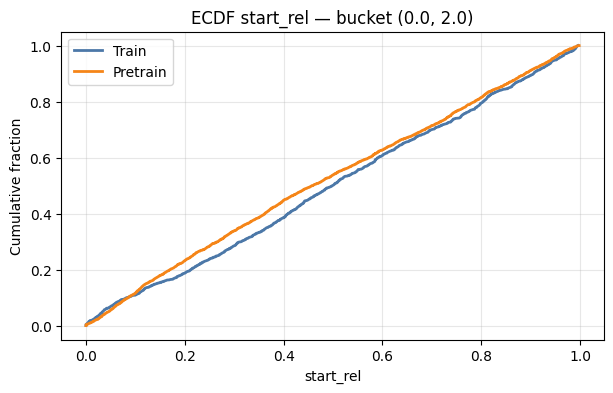

==== start_rel — BUCKET (0.0, 2.0) ====
start_rel        | KS D = 0.0634, p = 3.7e-05 | mean_train=0.502, mean_pre=0.476



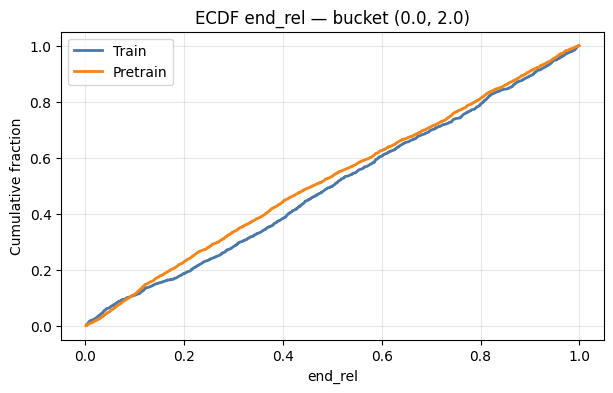

==== end_rel — BUCKET (0.0, 2.0) ====
end_rel          | KS D = 0.0630, p = 4.3e-05 | mean_train=0.505, mean_pre=0.479



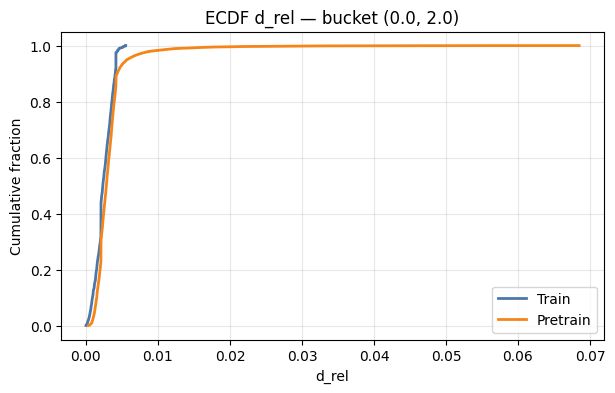

==== d_rel — BUCKET (0.0, 2.0) ====
d_rel            | KS D = 0.1401, p = 1.4e-23 | mean_train=0.002, mean_pre=0.003



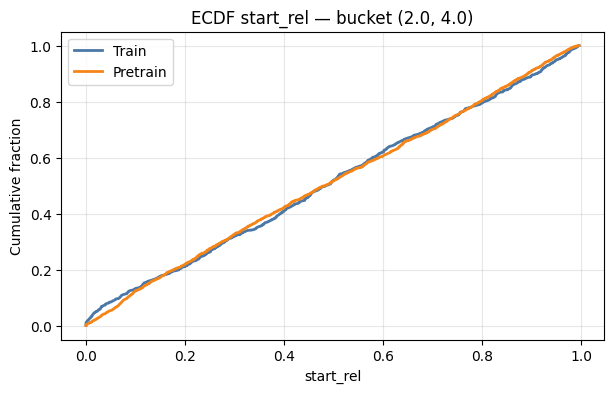

==== start_rel — BUCKET (2.0, 4.0) ====
start_rel        | KS D = 0.0326, p = 0.18 | mean_train=0.488, mean_pre=0.486



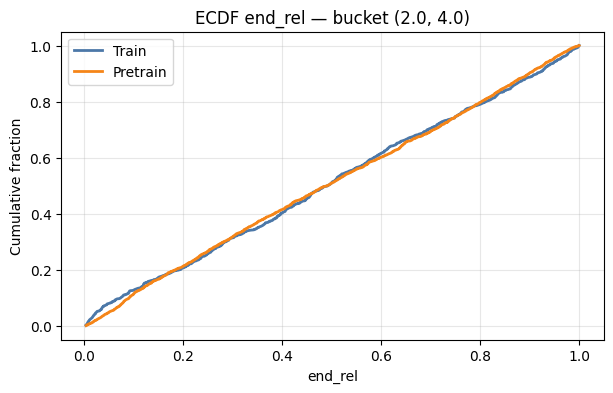

==== end_rel — BUCKET (2.0, 4.0) ====
end_rel          | KS D = 0.0335, p = 0.16 | mean_train=0.494, mean_pre=0.493



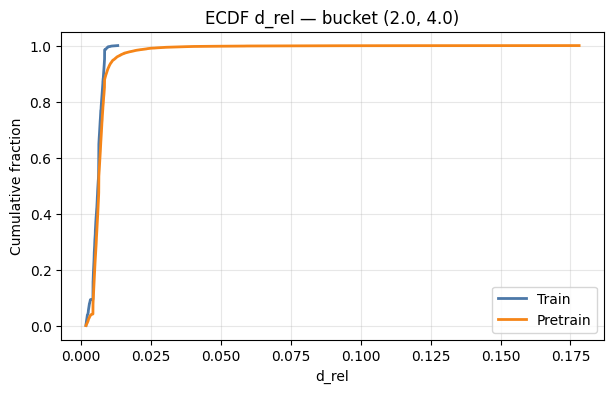

==== d_rel — BUCKET (2.0, 4.0) ====
d_rel            | KS D = 0.1252, p = 1.1e-15 | mean_train=0.006, mean_pre=0.007



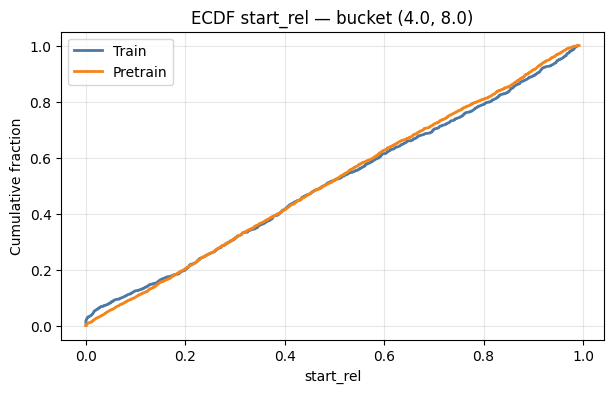

==== start_rel — BUCKET (4.0, 8.0) ====
start_rel        | KS D = 0.0337, p = 0.19 | mean_train=0.492, mean_pre=0.487



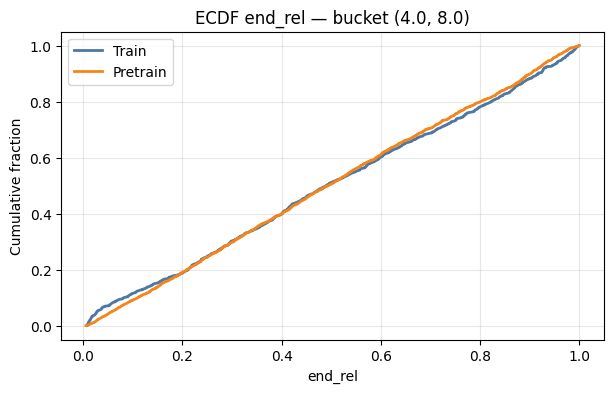

==== end_rel — BUCKET (4.0, 8.0) ====
end_rel          | KS D = 0.0342, p = 0.18 | mean_train=0.503, mean_pre=0.500



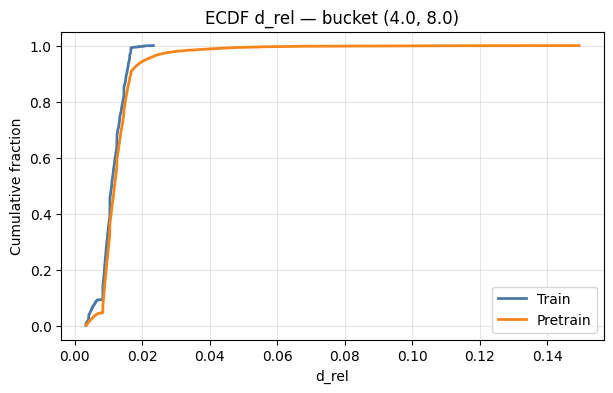

==== d_rel — BUCKET (4.0, 8.0) ====
d_rel            | KS D = 0.0945, p = 2.1e-08 | mean_train=0.011, mean_pre=0.013



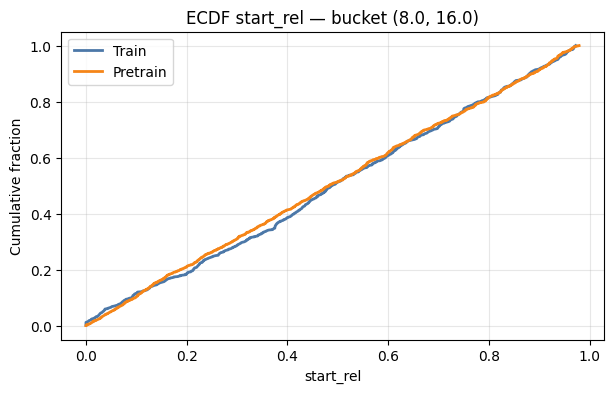

==== start_rel — BUCKET (8.0, 16.0) ====
start_rel        | KS D = 0.0401, p = 0.21 | mean_train=0.495, mean_pre=0.486



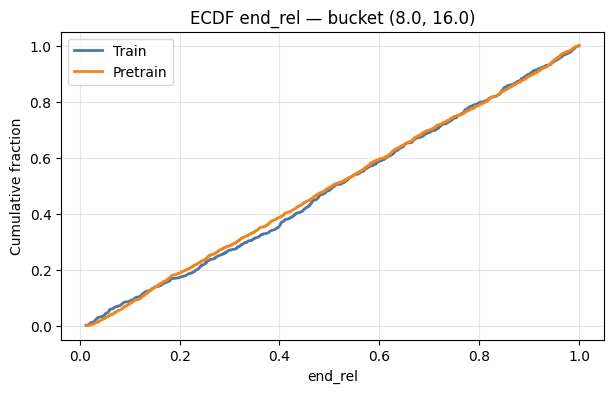

==== end_rel — BUCKET (8.0, 16.0) ====
end_rel          | KS D = 0.0360, p = 0.32 | mean_train=0.517, mean_pre=0.511



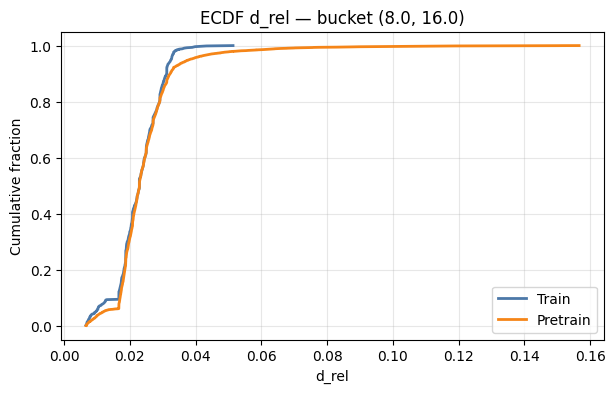

==== d_rel — BUCKET (8.0, 16.0) ====
d_rel            | KS D = 0.0576, p = 0.019 | mean_train=0.023, mean_pre=0.025



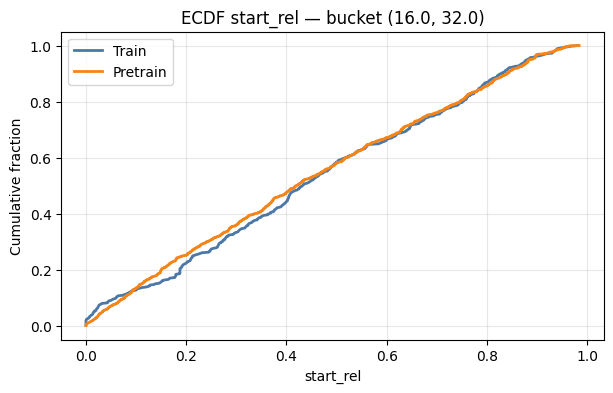

==== start_rel — BUCKET (16.0, 32.0) ====
start_rel        | KS D = 0.0619, p = 0.089 | mean_train=0.453, mean_pre=0.443



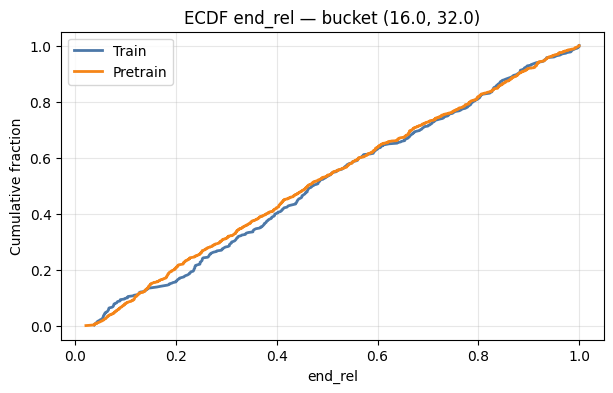

==== end_rel — BUCKET (16.0, 32.0) ====
end_rel          | KS D = 0.0562, p = 0.15 | mean_train=0.498, mean_pre=0.487



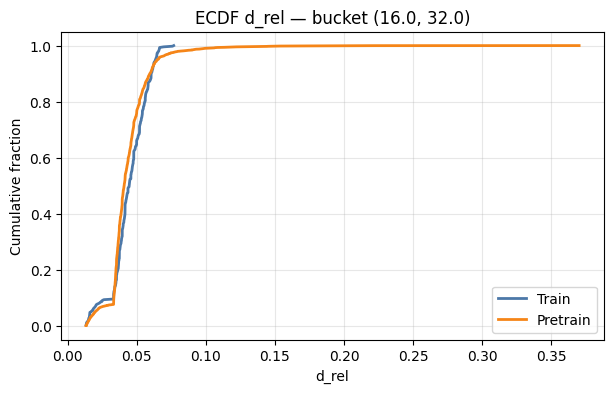

==== d_rel — BUCKET (16.0, 32.0) ====
d_rel            | KS D = 0.1267, p = 4.7e-06 | mean_train=0.045, mean_pre=0.044



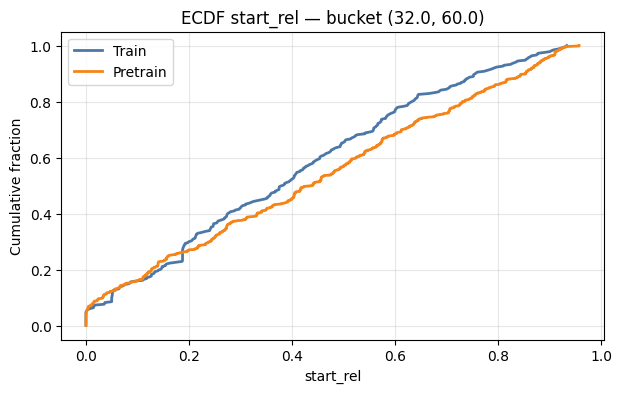

==== start_rel — BUCKET (32.0, 60.0) ====
start_rel        | KS D = 0.0920, p = 0.012 | mean_train=0.392, mean_pre=0.434



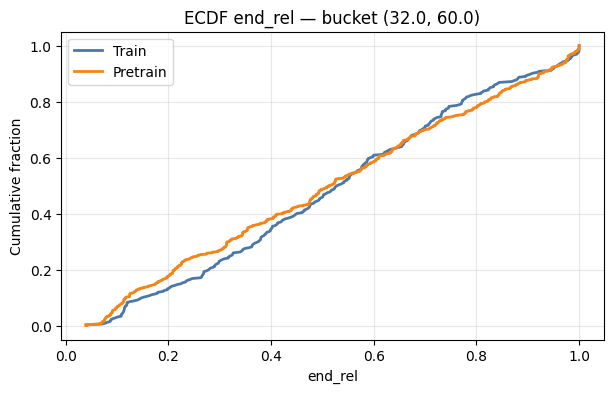

==== end_rel — BUCKET (32.0, 60.0) ====
end_rel          | KS D = 0.0849, p = 0.025 | mean_train=0.532, mean_pre=0.518



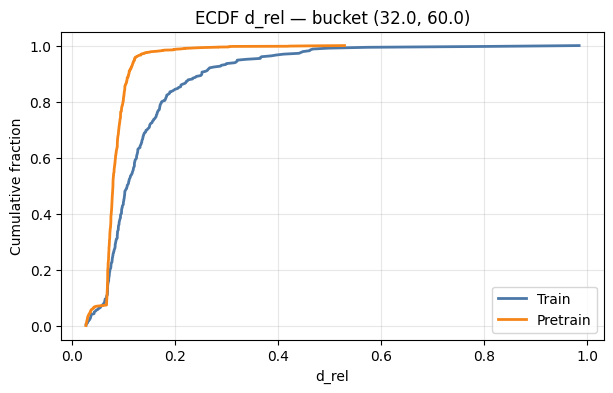

==== d_rel — BUCKET (32.0, 60.0) ====
d_rel            | KS D = 0.3900, p = 3.5e-41 | mean_train=0.140, mean_pre=0.085



In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from collections import defaultdict

TRAIN_JSON_PATH    = "nlq_train.json"
PRETRAIN_JSON_PATH = "nlq_pretrain.json"
DURATION_BUCKETS   = [0.0, 2.0, 4.0, 8.0, 16.0, 32.0, 60.0]

def canonical_bucket(b, edges=DURATION_BUCKETS):
    if isinstance(b, (tuple, list, np.ndarray)):
        return (float(b[0]), float(b[1]))
    return b

def bucket_of(d, edges=DURATION_BUCKETS):
    for i in range(len(edges)-1):
        if edges[i] <= d < edges[i+1]:
            return canonical_bucket((edges[i], edges[i+1]), edges)
    return canonical_bucket((edges[-2], edges[-1]), edges)

def extract_rel_pos_by_bucket(data, is_train=True):
    buckets = defaultdict(lambda: {"start_rel":[],"end_rel":[],"d_rel":[]})
    if is_train:
        for v in data["videos"]:
            for c in v["clips"]:
                cs, ce = float(c["clip_start_sec"]), float(c["clip_end_sec"])
                clen = ce - cs
                if clen <= 0: continue
                for a in c["annotations"]:
                    for q in a.get("language_queries", []):
                        s = q.get("video_start_sec", q.get("clip_start_sec"))
                        e = q.get("video_end_sec",   q.get("clip_end_sec"))
                        if s is None or e is None: continue
                        s, e = float(s), float(e)
                        if s < cs or e > ce or e <= s: continue
                        d   = e - s
                        B   = bucket_of(d, DURATION_BUCKETS)
                        buckets[B]["start_rel"].append((s-cs)/clen)
                        buckets[B]["end_rel"].append((e-cs)/clen)
                        buckets[B]["d_rel"].append((e-s)/clen)
    else:
        for q in data:
            cs = q.get("clip_start_sec")
            ce = q.get("clip_end_sec")
            s  = q.get("query_start_sec")
            e  = q.get("query_end_sec")
            if cs is None or ce is None or s is None or e is None: continue
            clen = float(ce) - float(cs)
            if clen <= 0 or float(e) <= float(s): continue
            d = float(e) - float(s)
            B = bucket_of(d, DURATION_BUCKETS)
            buckets[B]["start_rel"].append((float(s)-float(cs))/clen)
            buckets[B]["end_rel"].append((float(e)-float(cs))/clen)
            buckets[B]["d_rel"].append((float(e)-float(s))/clen)
    return buckets

def plot_ecdf(ax, data, label, color):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    ax.plot(x, y, label=label, color=color, linewidth=2)

def print_ks(name, train, pre):
    D, pvalue = ks_2samp(train, pre)
    print(f"{name:<16} | KS D = {D:.4f}, p = {pvalue:.2g} | mean_train={np.mean(train):.3f}, mean_pre={np.mean(pre):.3f}")

with open(TRAIN_JSON_PATH, "r") as f: train_json = json.load(f)
with open(PRETRAIN_JSON_PATH, "r") as f: pre_json = json.load(f)

train_buckets = extract_rel_pos_by_bucket(train_json, is_train=True)
pre_buckets   = extract_rel_pos_by_bucket(pre_json,  is_train=False)

# Breakdown grafico+statistico per bucket di durata
for B in DURATION_BUCKETS[:-1]:
    bucket = canonical_bucket((B, DURATION_BUCKETS[DURATION_BUCKETS.index(B)+1]))
    data_train = train_buckets.get(bucket, None)
    data_pre   = pre_buckets.get(bucket, None)
    if data_train is None or data_pre is None: continue
    for var in ["start_rel","end_rel","d_rel"]:
        arr_train = np.array(data_train[var])
        arr_pre   = np.array(data_pre[var])
        if len(arr_train) < 10 or len(arr_pre) < 10: continue # troppo pochi per analisi robusta
        fig, ax = plt.subplots(figsize=(7,4))
        plot_ecdf(ax, arr_train, "Train", "#4C78A8")
        plot_ecdf(ax, arr_pre,   "Pretrain", "#F58518")
        ax.set_title(f"ECDF {var} — bucket {bucket}")
        ax.set_xlabel(var)
        ax.set_ylabel("Cumulative fraction")
        ax.legend(); ax.grid(alpha=0.3)
        plt.show()
        print(f"==== {var} — BUCKET {bucket} ====")
        print_ks(var, arr_train, arr_pre)
        print("")


In [8]:
# === Check feature presence from merged good-queries and write missing UIDs ===
import os, json, pathlib

# --- CONFIG (aggiorna se necessario) ---
MERGED_JSON = "nlq_pretrain.json"
FEAT_V2_DIR = "ego4d_data/v1/omnivore_video_swinl_fp16/v1/omnivore_video_swinl_fp16/"
OUT_MISSING_TXT = "missing_uids_pretrain.txt"

# --- Helpers ---
def load_uids_from_json_or_jsonl(path):
    """
    Supporta:
      - .json con lista di dict che hanno 'video_uid'
      - .json con dict tipo {'data':[...]} o {'rows':[...]}
      - .jsonl (una riga = json) con 'video_uid'
      - eventuale formato Ego4D-style {'videos':[{'video_uid':...}, ...]}
    """
    uids = set()
    if path.endswith(".jsonl"):
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line=line.strip()
                if not line: continue
                try:
                    obj = json.loads(line)
                except Exception:
                    continue
                vid = obj.get("video_uid") or obj.get("videoId") or obj.get("uid")
                if not vid and isinstance(obj, dict) and "videos" in obj:
                    for v in obj.get("videos", []):
                        if isinstance(v, dict) and v.get("video_uid"):
                            uids.add(v["video_uid"])
                elif vid:
                    uids.add(str(vid))
    else:
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
        # caso lista di righe QA
        if isinstance(obj, list):
            for x in obj:
                if isinstance(x, dict) and x.get("video_uid"):
                    uids.add(str(x["video_uid"]))
        # caso dict wrapper
        elif isinstance(obj, dict):
            # Ego4D-style
            if "videos" in obj and isinstance(obj["videos"], list):
                for v in obj["videos"]:
                    if isinstance(v, dict) and v.get("video_uid"):
                        uids.add(str(v["video_uid"]))
            # altri wrapper comuni
            for key in ("data","rows","items"):
                if key in obj and isinstance(obj[key], list):
                    for x in obj[key]:
                        if isinstance(x, dict) and x.get("video_uid"):
                            uids.add(str(x["video_uid"]))
    return uids

def has_feat_pt(uid, base_dir):
    return os.path.exists(os.path.join(base_dir, f"{uid}.pt"))

# --- Run ---
all_uids = load_uids_from_json_or_jsonl(MERGED_JSON)
present = sorted([u for u in all_uids if has_feat_pt(u, FEAT_V2_DIR)])
missing = sorted([u for u in all_uids if u not in set(present)])

# write outputs
pathlib.Path(OUT_MISSING_TXT).write_text("\n".join(missing), encoding="utf-8")

print("=== REPORT (V2 / official_augmented) ===")
print(f"Totale video_uid nel merge: {len(all_uids):,}")
print(f"Presenti (.pt trovati)    : {len(present):,}")
print(f"Assenti (.pt mancanti)    : {len(missing):,}")
print()
print(f"Esempi mancanti (max 10): {missing[:10]}")
print()
print(f"Scritto file UID mancanti -> {OUT_MISSING_TXT}")


=== REPORT (V2 / official_augmented) ===
Totale video_uid nel merge: 1,498
Presenti (.pt trovati)    : 1,498
Assenti (.pt mancanti)    : 0

Esempi mancanti (max 10): []

Scritto file UID mancanti -> missing_uids_pretrain.txt


In [31]:
%%bash

ego4d \
  --version v1 \
  --output_directory ego4d_data/v1/omnivore_video_swinl_fp16 \
  --datasets omnivore_video_swinl_fp16 \
  --aws_profile_name ego4d \
  --yes
  


Datasets to download: {'omnivore_video_swinl_fp16'}
Download Path: ego4d_data/v1/omnivore_video_swinl_fp16/v1
Ego4D Metadata: ego4d_data/v1/omnivore_video_swinl_fp16/ego4d.json
Checking requested datasets and versions...
Created download directory for version 'v1' of dataset: 'omnivore_video_swinl_fp16' at: ego4d_data/v1/omnivore_video_swinl_fp16/v1/omnivore_video_swinl_fp16
Retrieving object metadata from S3...


100%|██████████| 9645/9645 [00:04<00:00, 2001.09object/s]


Checking if latest file versions are already downloaded...


100%|██████████| 9645/9645 [01:53<00:00, 84.80file/s] 


No existing videos to filter.


100%|█████████▉| 74.8G/74.8G [44:39<00:00, 19.6MiB/s]  

Checking file integrity...


100%|██████████| 74.8G/74.8G [44:40<00:00, 30.0MiB/s]


In [7]:
import json
import pandas as pd

INPUT_PATH = "nlq_pretrain.json"

print(f"Caricamento {INPUT_PATH}...")
with open(INPUT_PATH, 'r') as f:
    data = json.load(f)

# Rileva formato e appiattisci se necessario
rows = []
if isinstance(data, dict) and "videos" in data:
    print("Formato rilevato: NESTED (Ego4D style)")
    for v in data["videos"]:
        vid = v["video_uid"]
        for c in v["clips"]:
            cs, ce = c["clip_start_sec"], c["clip_end_sec"]
            for a in c["annotations"]:
                for q in a["language_queries"]:
                    rows.append({
                        "video_uid": vid,
                        "clip_start_sec": cs,
                        "clip_end_sec": ce,
                        # ... altri campi se servono ...
                    })
elif isinstance(data, list):
    print("Formato rilevato: FLAT (lista di query)")
    rows = data
else:
    raise ValueError("Formato JSON sconosciuto")

df = pd.DataFrame(rows)
print(f"DataFrame creato con {len(df)} righe.")

# Ora il groupby funzionerà
total_queries = len(df)
unique_windows = df.groupby(['video_uid', 'clip_start_sec', 'clip_end_sec']).size().shape[0]

print(f"Totale Query: {total_queries}")
print(f"Finestre Uniche (Clip): {unique_windows}")
print(f"Rapporto Query/Clip: {total_queries / unique_windows:.2f}")

if unique_windows > total_queries * 0.9:
    print("⚠️  CONFERMATO: Quasi ogni query ha la sua finestra. Il disco esploderà.")
else:
    print("✅ BENE: Ci sono molte query per finestra. Il raggruppamento ha funzionato.")

Caricamento nlq_pretrain.json...
Formato rilevato: FLAT (lista di query)
DataFrame creato con 39771 righe.
Totale Query: 39771
Finestre Uniche (Clip): 12580
Rapporto Query/Clip: 3.16
✅ BENE: Ci sono molte query per finestra. Il raggruppamento ha funzionato.
